### pickle의 단점 
* 무압축이기 때문에 데이터 용량이 크다 
* 파일을 디코딩할 때 동일한 패키지가 있어야 한다. (예: numpy)
* 파일 전체를 읽고 디코딩해야하므로 디스크에서 스트리밍 할 수 없다

## TFRecord 파일 포맷이란 무엇인가?


* TFRecord 파일은 텐서플로우로 딥러닝 학습을 하는데 필요한 데이터들을 보관하기 위한 데이타 포맷이다. 흔히들 텐서플로우의 표준 데이터 파일 포맷이라고도 한다. 
* TFRecord 파일은 바이너리 데이타 포맷으로 그 본질은 구글에 Protocol Buffer와도 같다. (파일에 데이터를 Serialize하게 저장함)   
* TFRecord 형식은 이진 레코드 시퀀스를 저장하기위한 간단한 형식

* 프로토콜 버퍼는 구조화 된 데이터의 효율적인 직렬화를위한 플랫폼 간, 언어 간 라이브러리입니다.
* 프로토콜 메시지는 .proto 파일로 정의되며 종종 메시지 유형을 이해하는 가장 쉬운 방법입니다.
* tf.train.Example 메시지 (또는 protobuf)는 {"string": value} 매핑을 나타내는 유연한 메시지 유형입니다. TensorFlow와 함께 사용하도록 설계되었으며 TFX 와 같은 상위 수준 API 전체에서 사용됩니다.

import tensorflow as tf

### 강아지 품종 

In [14]:
# Pandas and Numpy for data structures and util fucntions
import numpy as np
import pandas as pd
from numpy.random import rand

pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn.model_selection import train_test_split

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation,Dense
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [16]:
train_folder = './data\dog-breed-identification/train/'
test_folder = './data\dog-breed-identification/test/'

In [18]:
# kaggle에서 받은 데이터
data_labels = pd.read_csv('./data\dog-breed-identification\labels.csv')
data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [19]:
target_labels = data_labels['breed']
len(set(target_labels))

120

In [21]:
data_labels['image_path'] = data_labels.apply( lambda row: (train_folder + row["id"] + ".jpg" ), axis=1)
data_labels.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,./data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,./data/train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,./data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,./data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg


 tf.train.Example 데이터 유형

기본적으로 tf.train.Example 은 {"string": tf.train.Feature} 매핑입니다.

tf.train.Feature 메시지 유형은 다음 세 가지 유형 중 하나를 허용 할 수 있습니다 (참조는 .proto 파일 참조). 대부분의 다른 일반 유형은 다음 중 하나로 강제 변환 될 수 있습니다.

    tf.train.BytesList (다음 유형을 강제 변환 할 수 있음)
        string
        byte

    tf.train.FloatList (다음 유형을 강제 변환 할 수 있음)
        float ( float32 )
        double ( float64 )

    tf.train.Int64List (다음 유형을 강제 변환 할 수 있음)
        bool
        enum
        int32
        uint32
        int64
        uint64

표준 TensorFlow 유형을 tf.train.Example 호환 tf.train.Feature 로 변환하려면 아래 바로 가기 함수를 사용할 수 있습니다. 각 함수는 스칼라 입력 값을 취하고 위의 세 가지 list 유형 중 하나를 포함하는 tf.train.Feature 를 반환합니다.

In [206]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value])) #byte -> 속도가 빠름

# def _float_feature(value):
#   """Returns a float_list from a float / double."""
#   return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value])) #int 
                                                                         #value 값은 리스트로 삽입 (value가 배열이면 그냥 넣으면 되고, 스칼라라면 []리스트로 감싸서 보내야함)

# def _int64_list_feature(value):
#   """Returns an int64_list from a bool / enum / int / uint."""
#   return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

* tensorflow에서 이미지 읽고 사이즈 변환

In [181]:
image_string = "./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg"
image = tf.io.read_file(image_string)
image = tf.image.decode_jpeg(image)
image = tf.image.convert_image_dtype(image, tf.float32) #데이터 형태를 변경
image = tf.image.resize(image, [299, 299]) #이미지 사이즈가 제각각이므로 사이즈 일괄 변경

* 이미지 출력

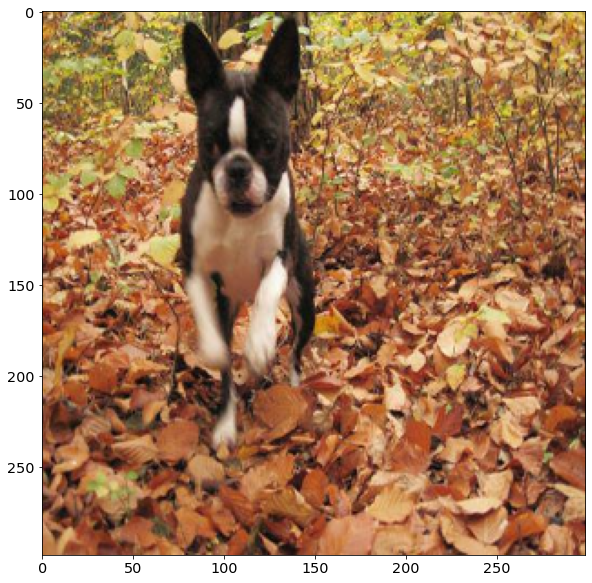

In [155]:
img = plt.imshow(image_raw)

def serialize_example(image, label):
    feature = {
        "image": tf.train.Feature(float_list = tf.train.FloatList(value=image.flatten())),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value= label.flatten())),
        "shape": tf.train.Feature(int64_list=tf.train.Int64List(value=image.shape))
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def image_example(image_string, label):
    image = tf.io.read_file(image_string)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [299, 299])
    image_shape = image.shape

    feature = {
          'height': _int64_feature(image_shape[0]),
          'width': _int64_feature(image_shape[1]),
          'depth': _int64_feature(image_shape[2]),
          'label': _int64_list_feature(label),
          'image_raw': _float_feature(image.numpy().flatten()),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
image.shape

In [385]:
def image_example(image_string, label):
    global image
    image = tf.io.read_file(image_string)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [299, 299])
    image_shape = image.shape

    #구조를 정한 뒤, 형태도 정해주기
    feature = {#딕셔너리 형태
          #이 정보는 쓰지 않을 경우 지워도 되고, 정보를 추가할 경우 추가해주면 됨 -> TFrecord 파일 읽을때도 같이 삭제, 추가
          'height':    _int64_feature(image_shape[0]),
          'width':     _int64_feature(image_shape[1]),
          'depth':     _int64_feature(image_shape[2]),
          'label':     _bytes_feature(label), #바이트 형식 -> 바이트로 하면 생성속도가 빠름
          'image_raw': _bytes_feature(image.numpy().tobytes()), #바이트 형식 -> 바이트로 하면 생성속도가 빠름
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
target_labels[0],encode() #b가 붙은 경우 : byte 형태라는 뜻

In [386]:
# 테스트 
image_string = "./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg"
tf_example = image_example(image_string, label) #여기에서 바이트 형태로 넣을 것이기 때문에 바이트 형태로 변경해줘야함

In [ ]:
data_labels.hear(1)

In [388]:
file_path = "test2.tfrecords"
with tf.io.TFRecordWriter(file_path) as writer: #with 구문 : 느린 연산 -> 
    for idx, row in data_labels.iterrows():
        if idx % 100 == 0 : print(idx) #전체 다 돌려보는 코드
#         print (row['breed'], row['image_path'])
#         if idx == 100: break
        rt = image_example(row['image_path'], row['breed'].encode())
        writer.write(rt.SerializeToString()) #직렬화된 데이터를 스트링으로 저장

boston_bull ./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg
dingo ./data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
pekinese ./data/train/001cdf01b096e06d78e9e5112d419397.jpg
bluetick ./data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg
golden_retriever ./data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg
bedlington_terrier ./data/train/002211c81b498ef88e1b40b9abf84e1d.jpg
bedlington_terrier ./data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg
borzoi ./data/train/002a283a315af96eaea0e28e7163b21b.jpg
basenji ./data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg
scottish_deerhound ./data/train/0042188c895a2f14ef64a918ed9c7b64.jpg
shetland_sheepdog ./data/train/004396df1acd0f1247b740ca2b14616e.jpg
walker_hound ./data/train/0067dc3eab0b3c3ef0439477624d85d6.jpg
maltese_dog ./data/train/00693b8bc2470375cc744a6391d397ec.jpg
bluetick ./data/train/006cc3ddb9dc1bd827479569fcdc52dc.jpg
norfolk_terrier ./data/train/0075dc49dab4024d12fafe67074d8a81.jpg
african_hunting_dog ./data/train/00792e341f3c6eb33663e415

## TFrecord 파일 읽기

In [389]:
raw_image_dataset = tf.data.TFRecordDataset('test2.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width':         tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'label':     tf.io.FixedLenFeature([120], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string                                                                                                                                     ),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)


In [ ]:
parsed_image_dataset = raw_image_dataset.map(_parse_image_function) 
parsed_image_dataset

In [ ]:
total_image = []
total_label = []

for image_features in parsed_image_dataset:
    total_image.append(np.frombuffer(image_features['image_raw'].numpy(), dtype=np.float32).reshape(299, 299,3))
    total_label.append(image_features['label'].numpy().decode())
#     break

In [ ]:
#방법 1
train = np.array(total_image)

In [ ]:
train.shape 

In [ ]:
train_data.shape

In [ ]:
del total_image, total_label #메모리에서 삭제 -> 삭제가 안되기 때문에 따로 해줘야함

In [ ]:
#방법 2
#메모리를 덜 사용하기 위해 이렇게 해보는 건 어떨지
#한 번에
train_data = np.array([np.frombuffer(image_features['image_raw'].numpy(), dtype=np.float32).reshape(299, 299,3)
                       for image_features in parsed_image_dataset ])

In [ ]:
train_data.shape

In [ ]:
train_label = np.array([image_features['label'].numpy().decode() 
                       for image_features in parsed_image_dataset ])

In [ ]:
train_label[0]

* 샘플 이미지 출력해보기

In [402]:
a = image_features['image_raw'].numpy() 

In [ ]:
a # 바이트 형식

In [405]:
a_image = np.frombuffer(a, dtype=np.float32)

In [ ]:
a_image #데이터 형식

In [ ]:
a_image.shape #299, 299, 3

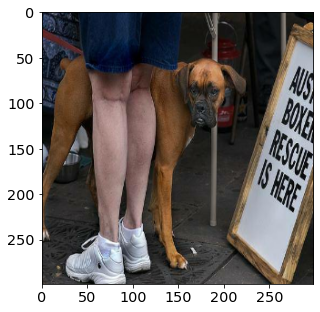

In [410]:
plt.imshow(a_image.reshape(299,299,3))